# Test 2: Style Bias - Visualizations

This notebook provides visual analysis of style bias in resume seniority predictions.

**Question we're answering:** Does the WAY someone writes their resume affect how AI models judge their seniority?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Load data
df_orig = pd.read_csv("../Test 2 Data/test2_resumes.csv")

# Try to load both prediction files
try:
    ft_df = pd.read_csv("finetuned_predictions.csv")
    print(f"Loaded finetuned predictions: {len(ft_df)} rows")
except:
    ft_df = None
    print("Finetuned predictions not found")

try:
    llm_df = pd.read_csv("llm_predictions.csv")
    llm_df = llm_df[~llm_df['prediction'].isin(['error', 'unknown'])]
    print(f"Loaded LLM predictions: {len(llm_df)} rows")
except:
    llm_df = None
    print("LLM predictions not found")

Loaded finetuned predictions: 720 rows
Loaded LLM predictions: 1078 rows


In [2]:
# Prepare data
seniority_rank = {'junior': 0, 'mid': 1, 'senior': 2}

def prepare_df(df):
    if df is None:
        return None
    df = df.copy()
    df['true_rank'] = df['true_seniority'].map(seniority_rank)
    df['pred_rank'] = df['prediction'].map(seniority_rank)
    df['rank_diff'] = df['pred_rank'] - df['true_rank']
    return df

ft_df = prepare_df(ft_df)
llm_df = prepare_df(llm_df)

# Get model names
ft_models = ft_df['model'].unique().tolist() if ft_df is not None else []
llm_models = llm_df['model'].unique().tolist() if llm_df is not None else []
all_models = ft_models + llm_models
print(f"Models: {all_models}")

Models: ['distilbert', 'roberta', 'sonnet45', 'gpt5', 'gemini3']


---
## Visual 1: Accuracy by Resume Style

### What This Analysis Shows
This chart displays how accurately each model predicts the correct seniority level (junior, mid, or senior) when given resumes written in different styles.

### Why This Matters
In a fair system, writing style should NOT affect accuracy. If a model predicts correctly 80% of the time for neutral resumes but only 50% for overstated resumes, it means the confident language is **confusing** the model. The model might be:
- Promoting juniors who use power words
- Demoting seniors who write modestly

### How to Interpret
- **Equal bar heights** = Good! The model focuses on actual experience, not writing style.
- **Overstated accuracy < Neutral accuracy** = The power words are misleading the model.
- **Understated accuracy < Neutral accuracy** = Humble language makes real experience invisible.
- **Overstated accuracy < Understated accuracy** = Particularly concerning - confident language actively hurts accuracy.

### What to Look For
Compare finetuned models (DistilBERT, RoBERTa) vs LLMs (GPT-5, Gemini, Sonnet). Do SOTA LLMs handle style variation better?

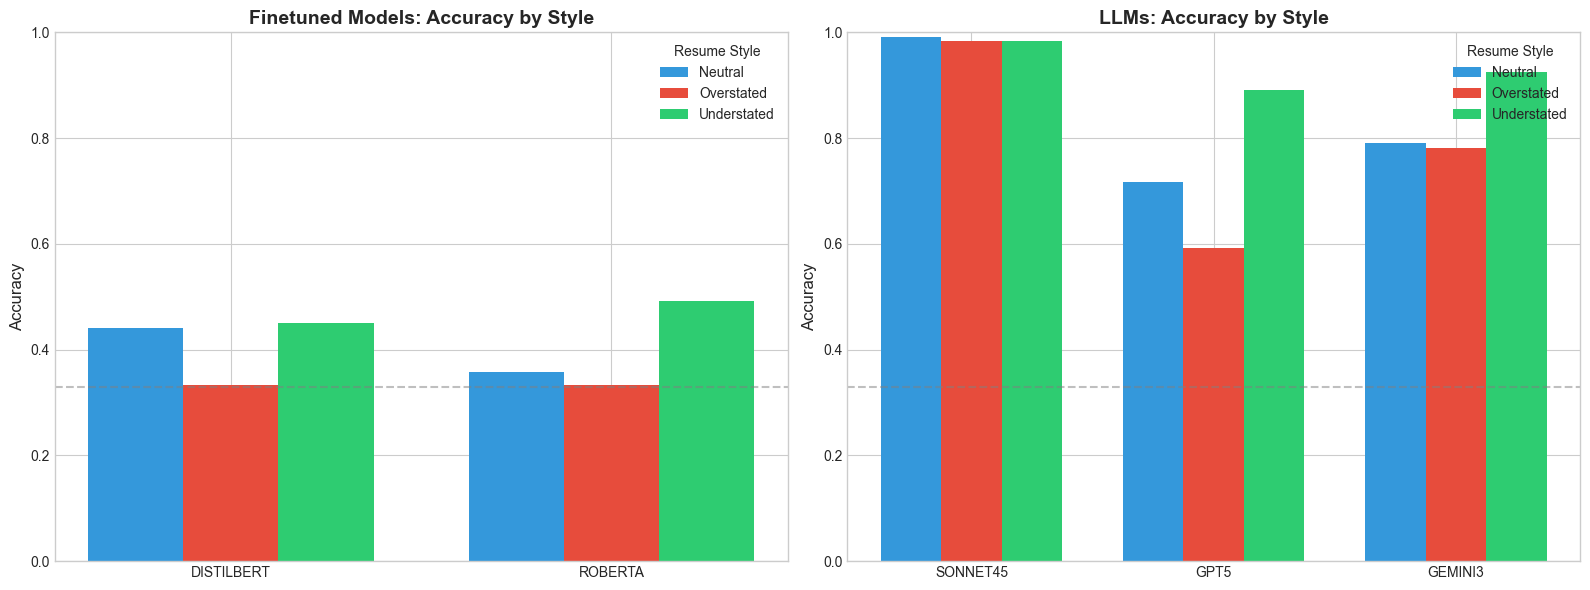

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
styles = ['neutral', 'overstated', 'understated']
colors = {'neutral': '#3498db', 'overstated': '#e74c3c', 'understated': '#2ecc71'}

# Finetuned models
if ft_df is not None:
    x = np.arange(len(ft_models))
    width = 0.25
    
    for i, style in enumerate(styles):
        accs = [ft_df[(ft_df['model'] == m) & (ft_df['style'] == style)]['correct'].mean() 
                for m in ft_models]
        axes[0].bar(x + i*width, accs, width, label=style.capitalize(), color=colors[style])
    
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Finetuned Models: Accuracy by Style', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x + width)
    axes[0].set_xticklabels([m.upper() for m in ft_models])
    axes[0].legend(title='Resume Style')
    axes[0].set_ylim(0, 1)
    axes[0].axhline(y=0.33, color='gray', linestyle='--', alpha=0.5, label='Random guess')

# LLM models
if llm_df is not None:
    x = np.arange(len(llm_models))
    width = 0.25
    
    for i, style in enumerate(styles):
        accs = [llm_df[(llm_df['model'] == m) & (llm_df['style'] == style)]['correct'].mean() 
                for m in llm_models]
        axes[1].bar(x + i*width, accs, width, label=style.capitalize(), color=colors[style])
    
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('LLMs: Accuracy by Style', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels([m.upper() for m in llm_models])
    axes[1].legend(title='Resume Style')
    axes[1].set_ylim(0, 1)
    axes[1].axhline(y=0.33, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('viz1_accuracy_by_style.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Visual 2: Prediction Bias (Rank Difference) by Style

### What This Analysis Shows
This chart shows the **average rank difference** for each style, where:
- Rank difference = Predicted seniority rank - True seniority rank
- Seniority ranks: Junior=0, Mid=1, Senior=2

### Why This Matters
Accuracy alone doesn't tell the full story. A model could be 50% accurate but consistently wrong in one direction:
- **Always underestimating** (predicting junior when they're senior)
- **Always overestimating** (predicting senior when they're junior)

This is critical for fairness: If overstated resumes get systematically overestimated, people who exaggerate their achievements get unfair advantages.

### How to Interpret
- **Bar at 0** = No systematic bias (predictions are scattered evenly around truth)
- **Positive bar (+)** = Model overestimates seniority (predicts higher than reality)
- **Negative bar (-)** = Model underestimates seniority (predicts lower than reality)
- **+1.0** means on average predicting ONE full level too high (all juniors → mid, all mids → senior)

### What to Look For
- Is the overstated bar higher than neutral? → Style bias exists
- Is the understated bar lower than neutral? → Humble language gets penalized
- Are LLMs closer to 0 than finetuned models? → LLMs are more robust

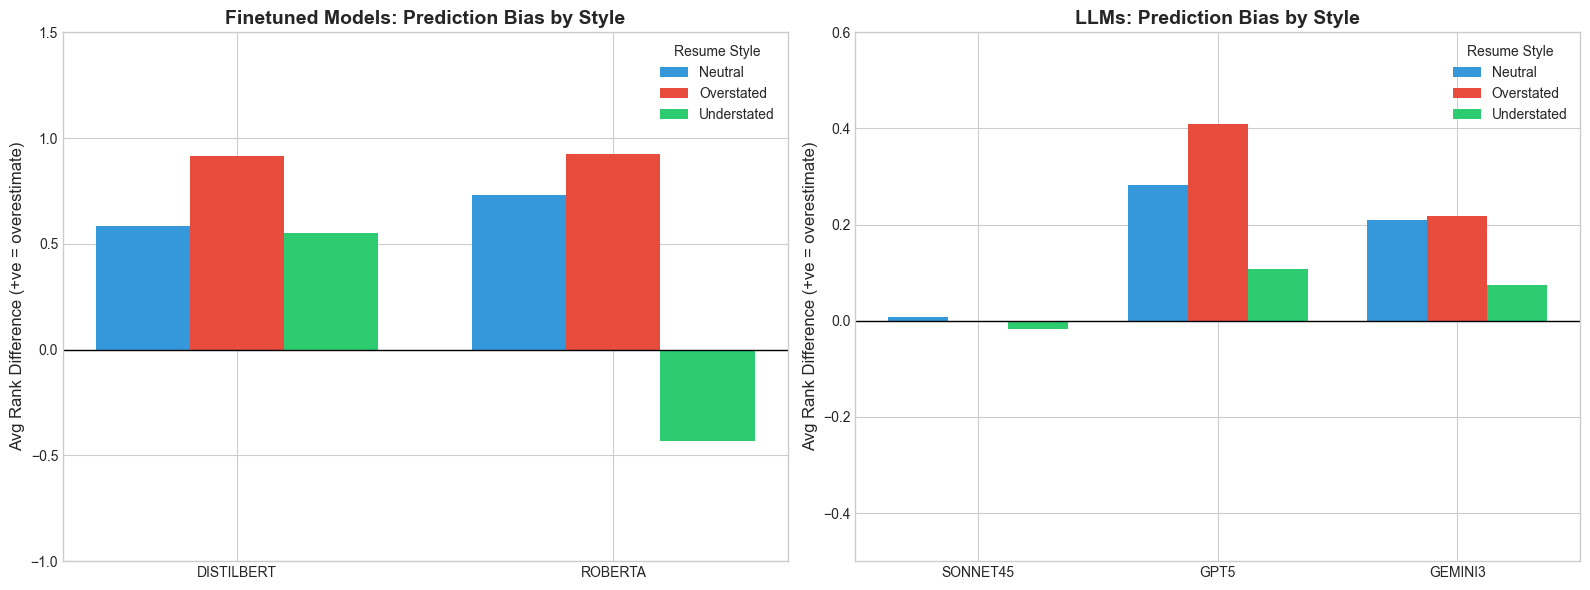

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Finetuned models
if ft_df is not None:
    x = np.arange(len(ft_models))
    width = 0.25
    
    for i, style in enumerate(styles):
        diffs = [ft_df[(ft_df['model'] == m) & (ft_df['style'] == style)]['rank_diff'].mean() 
                 for m in ft_models]
        axes[0].bar(x + i*width, diffs, width, label=style.capitalize(), color=colors[style])
    
    axes[0].set_ylabel('Avg Rank Difference (+ve = overestimate)', fontsize=12)
    axes[0].set_title('Finetuned Models: Prediction Bias by Style', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x + width)
    axes[0].set_xticklabels([m.upper() for m in ft_models])
    axes[0].legend(title='Resume Style')
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[0].set_ylim(-1, 1.5)

# LLM models
if llm_df is not None:
    x = np.arange(len(llm_models))
    width = 0.25
    
    for i, style in enumerate(styles):
        diffs = [llm_df[(llm_df['model'] == m) & (llm_df['style'] == style)]['rank_diff'].mean() 
                 for m in llm_models]
        axes[1].bar(x + i*width, diffs, width, label=style.capitalize(), color=colors[style])
    
    axes[1].set_ylabel('Avg Rank Difference (+ve = overestimate)', fontsize=12)
    axes[1].set_title('LLMs: Prediction Bias by Style', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels([m.upper() for m in llm_models])
    axes[1].legend(title='Resume Style')
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
    axes[1].set_ylim(-0.5, 0.6)

plt.tight_layout()
plt.savefig('viz2_bias_by_style.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Visual 3: Juniors Predicted as Senior ("Promotion Rate")

### What This Analysis Shows
This is the most direct measure of style bias: What percentage of **actual juniors** get mispredicted as **senior** based on writing style?

### Why This Matters
This represents the worst-case scenario for hiring bias:
- A junior with 1-2 years experience writes confidently → AI thinks they're senior
- They might get hired for a senior role they're not qualified for
- Meanwhile, a senior who writes modestly might get overlooked

This is especially problematic because:
1. It rewards people who exaggerate (ethical concern)
2. It penalizes people from cultures that value modesty (cultural bias)
3. It can lead to bad hires (business impact)

### How to Interpret
- **Ideal: 0%** for all styles - no juniors should be predicted as senior
- **Overstated >> Neutral** = Style bias is actively promoting unqualified candidates
- **50%+ for overstated** = Extreme bias - overstating has a coin-flip chance of getting you "promoted"

### What to Look For
Compare the red bars (overstated) vs blue bars (neutral). The gap between them quantifies how much confident writing "promotes" juniors.

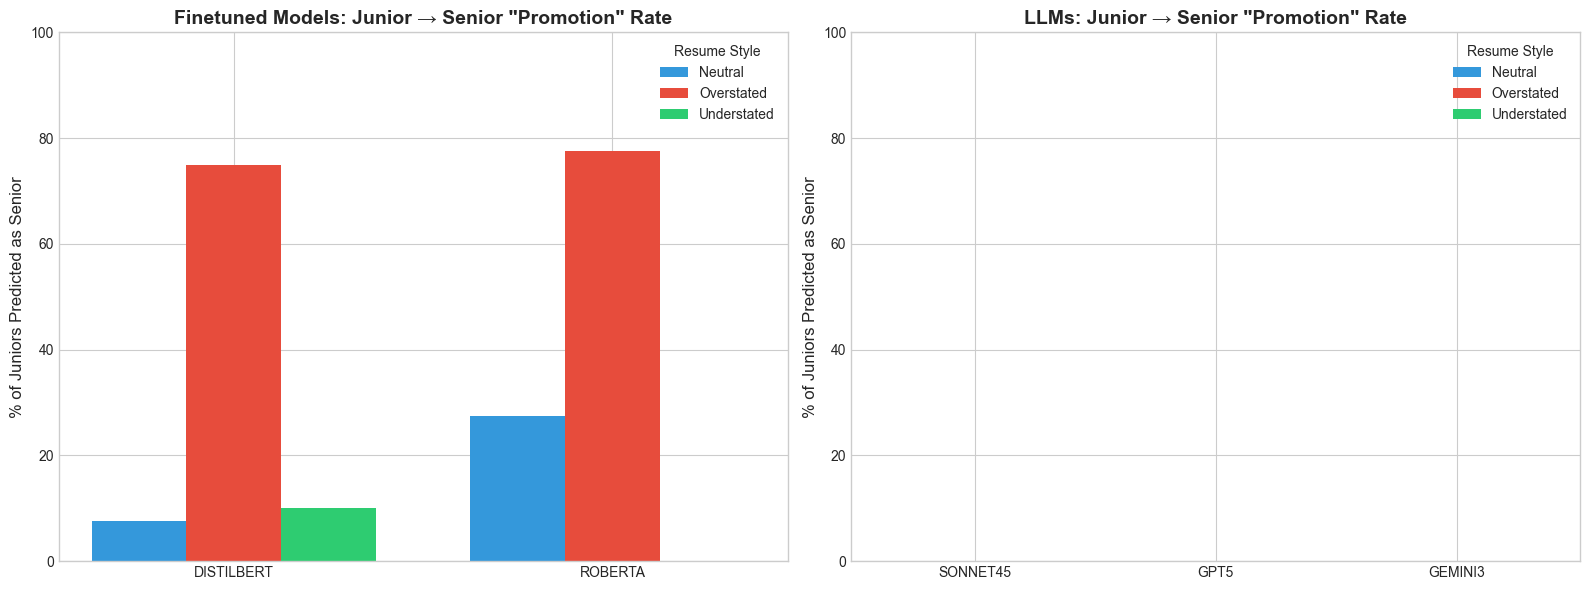

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def calc_promotion_rate(df, model, style):
    subset = df[(df['model'] == model) & (df['style'] == style) & (df['true_seniority'] == 'junior')]
    if len(subset) == 0:
        return 0
    return (subset['prediction'] == 'senior').mean() * 100

# Finetuned models
if ft_df is not None:
    x = np.arange(len(ft_models))
    width = 0.25
    
    for i, style in enumerate(styles):
        rates = [calc_promotion_rate(ft_df, m, style) for m in ft_models]
        axes[0].bar(x + i*width, rates, width, label=style.capitalize(), color=colors[style])
    
    axes[0].set_ylabel('% of Juniors Predicted as Senior', fontsize=12)
    axes[0].set_title('Finetuned Models: Junior → Senior "Promotion" Rate', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x + width)
    axes[0].set_xticklabels([m.upper() for m in ft_models])
    axes[0].legend(title='Resume Style')
    axes[0].set_ylim(0, 100)

# LLM models  
if llm_df is not None:
    x = np.arange(len(llm_models))
    width = 0.25
    
    for i, style in enumerate(styles):
        rates = [calc_promotion_rate(llm_df, m, style) for m in llm_models]
        axes[1].bar(x + i*width, rates, width, label=style.capitalize(), color=colors[style])
    
    axes[1].set_ylabel('% of Juniors Predicted as Senior', fontsize=12)
    axes[1].set_title('LLMs: Junior → Senior "Promotion" Rate', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels([m.upper() for m in llm_models])
    axes[1].legend(title='Resume Style')
    axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.savefig('viz3_junior_promotion_rate.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Visual 4: Prediction Inconsistency (Same Person, Different Styles)

### What This Analysis Shows
For each person, we check if their 3 resume versions (neutral, overstated, understated) get the same prediction. This chart shows what percentage of people got **inconsistent predictions** - meaning changing their writing style changed the AI's judgment.

### Why This Matters
This is the purest test of style bias because:
- The resume content is IDENTICAL (same experience, skills, education)
- Only the WORDING changed
- If predictions differ, the model is reacting to style, not substance

An unbiased model should give the SAME prediction regardless of how confidently someone writes. A 40% inconsistency rate means 40% of candidates would get different evaluations just by changing their word choices.

### How to Interpret
- **0% = Perfect** - Style has zero influence on predictions
- **10-20%** = Moderate bias - some influence from writing style
- **30%+** = Severe bias - writing style significantly affects outcomes
- **50%+** = Critical - might as well flip a coin based on style

### What to Look For
Which models are most consistent? Lower bars indicate more robust, fair models that judge on content rather than presentation.

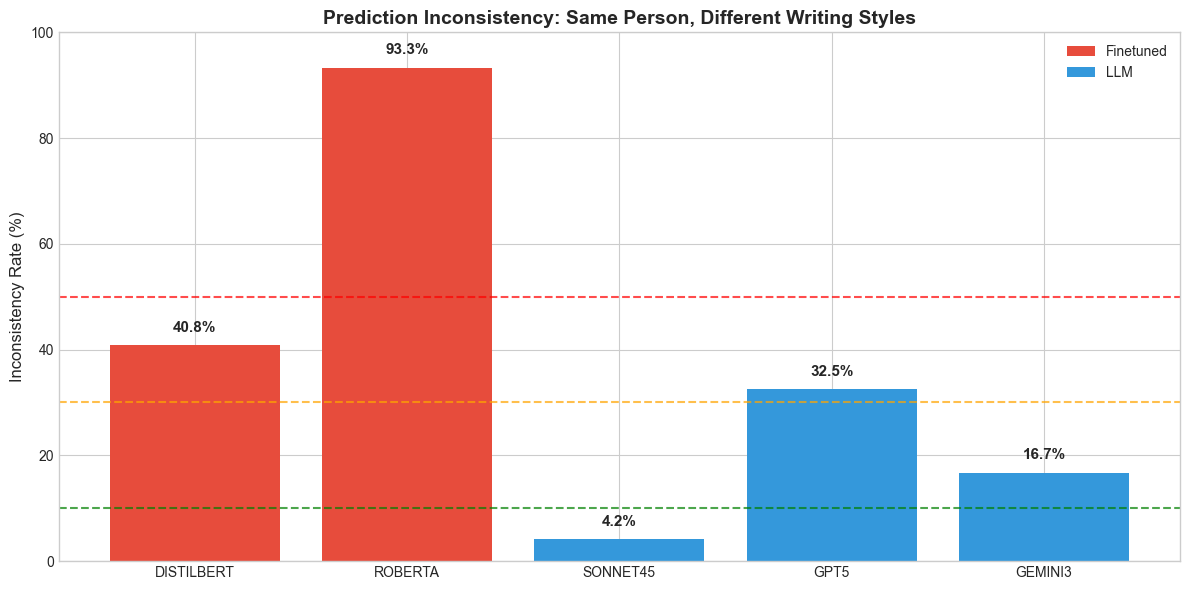

In [6]:
def calc_inconsistency(df, model):
    model_df = df[df['model'] == model]
    inconsistent = 0
    total = 0
    for idx in model_df['idx'].unique():
        preds = model_df[model_df['idx'] == idx]['prediction'].unique()
        if len(preds) > 1:
            inconsistent += 1
        total += 1
    return (inconsistent / total * 100) if total > 0 else 0

fig, ax = plt.subplots(figsize=(12, 6))

all_data = []
all_labels = []
all_colors = []

if ft_df is not None:
    for m in ft_models:
        all_data.append(calc_inconsistency(ft_df, m))
        all_labels.append(m.upper())
        all_colors.append('#e74c3c')  # Red for finetuned

if llm_df is not None:
    for m in llm_models:
        all_data.append(calc_inconsistency(llm_df, m))
        all_labels.append(m.upper())
        all_colors.append('#3498db')  # Blue for LLMs

bars = ax.bar(all_labels, all_data, color=all_colors)
ax.set_ylabel('Inconsistency Rate (%)', fontsize=12)
ax.set_title('Prediction Inconsistency: Same Person, Different Writing Styles', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

# Add value labels on bars
for bar, val in zip(bars, all_data):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Finetuned'),
                   Patch(facecolor='#3498db', label='LLM')]
ax.legend(handles=legend_elements, loc='upper right')

# Add threshold lines
ax.axhline(y=10, color='green', linestyle='--', alpha=0.7, label='Good (<10%)')
ax.axhline(y=30, color='orange', linestyle='--', alpha=0.7, label='Moderate')
ax.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Severe')

plt.tight_layout()
plt.savefig('viz4_inconsistency_rate.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Visual 5: Word Influence - Power Words in Predictions

### What This Analysis Shows
This chart shows the average number of "power words" (strategic, spearheaded, architected, etc.) found in resumes that received each prediction level.

### Why This Matters
This reveals WHAT the model is actually responding to. If resumes predicted as "senior" have 15 power words on average while "junior" predictions have only 2, the model is clearly associating confident language with seniority - regardless of actual experience.

Power words include:
- Strong verbs: spearheaded, revolutionized, pioneered, architected
- Impact words: strategic, critical, comprehensive, innovative
- Scale words: enterprise-wide, global, organization-wide

### How to Interpret
- **Similar heights across predictions** = Good! Model ignores word choice.
- **Senior >> Junior** = Model associates power words with seniority (biased)
- **Steep gradient (senior to junior)** = Strong word-based bias

### What to Look For
Compare the gradient (slope from senior to junior) across models. Flatter = more robust to word choice.

In [7]:
POWER_WORDS = {
    'spearheaded', 'revolutionized', 'pioneered', 'orchestrated', 'architected',
    'transformed', 'drove', 'championed', 'accelerated', 'maximized',
    'optimized', 'elevated', 'propelled', 'commanded', 'masterminded',
    'dramatically', 'significantly', 'substantially', 'exponentially', 'exceptionally',
    'outstanding', 'exceptional', 'remarkable', 'extraordinary', 'tremendous',
    'critical', 'crucial', 'vital', 'strategic', 'innovative',
    'enterprise', 'comprehensive', 'extensive', 'robust', 'cutting-edge',
    'visionary', 'influential', 'instrumental', 'pivotal', 'key'
}

def count_power_words(text):
    words = re.findall(r'\b[a-z]+\b', str(text).lower())
    return sum(1 for w in words if w in POWER_WORDS)

# Add power word counts if not present
if ft_df is not None and 'power_count' not in ft_df.columns:
    ft_df['power_count'] = ft_df['resume_text'].apply(count_power_words)
if llm_df is not None and 'power_count' not in llm_df.columns:
    llm_df['power_count'] = llm_df['resume_text'].apply(count_power_words)

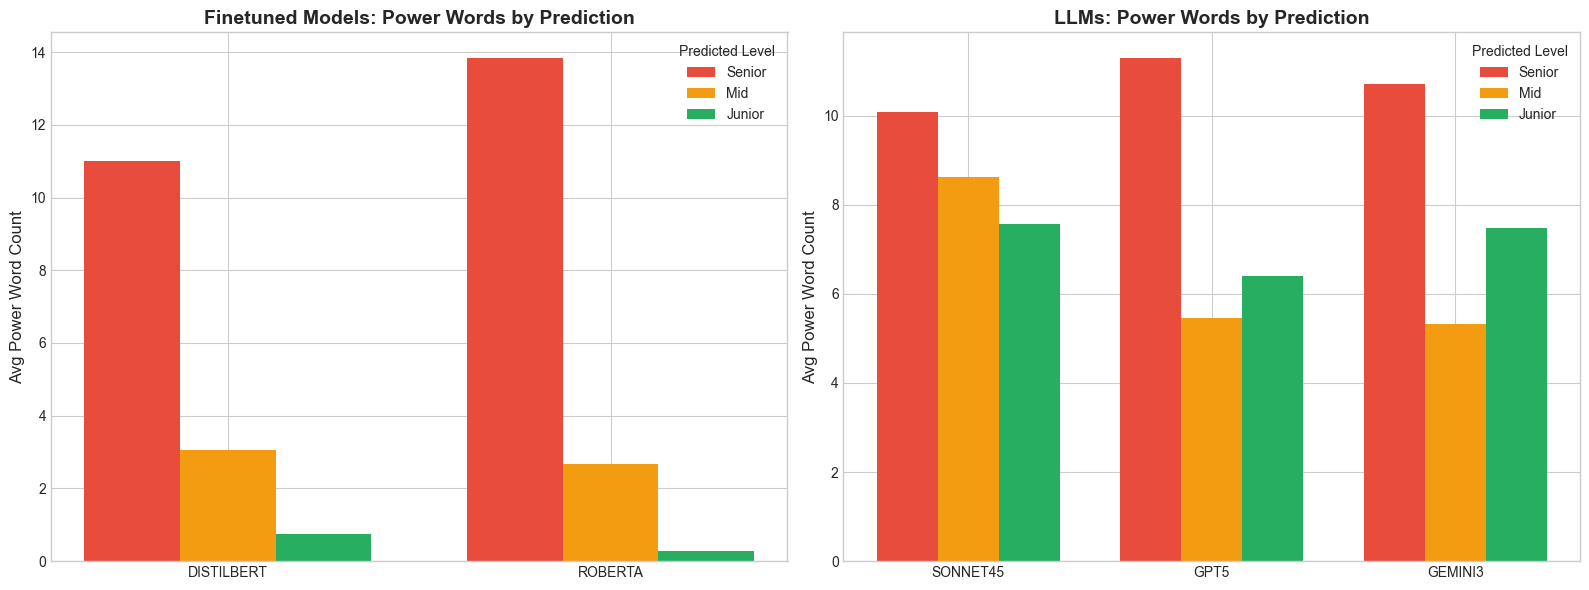

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
pred_levels = ['senior', 'mid', 'junior']
pred_colors = {'senior': '#e74c3c', 'mid': '#f39c12', 'junior': '#27ae60'}

# Finetuned models
if ft_df is not None:
    x = np.arange(len(ft_models))
    width = 0.25
    
    for i, pred in enumerate(pred_levels):
        counts = [ft_df[(ft_df['model'] == m) & (ft_df['prediction'] == pred)]['power_count'].mean() 
                  for m in ft_models]
        axes[0].bar(x + i*width, counts, width, label=pred.capitalize(), color=pred_colors[pred])
    
    axes[0].set_ylabel('Avg Power Word Count', fontsize=12)
    axes[0].set_title('Finetuned Models: Power Words by Prediction', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x + width)
    axes[0].set_xticklabels([m.upper() for m in ft_models])
    axes[0].legend(title='Predicted Level')

# LLM models
if llm_df is not None:
    x = np.arange(len(llm_models))
    width = 0.25
    
    for i, pred in enumerate(pred_levels):
        counts = [llm_df[(llm_df['model'] == m) & (llm_df['prediction'] == pred)]['power_count'].mean() 
                  for m in llm_models]
        axes[1].bar(x + i*width, counts, width, label=pred.capitalize(), color=pred_colors[pred])
    
    axes[1].set_ylabel('Avg Power Word Count', fontsize=12)
    axes[1].set_title('LLMs: Power Words by Prediction', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels([m.upper() for m in llm_models])
    axes[1].legend(title='Predicted Level')

plt.tight_layout()
plt.savefig('viz5_power_words_by_prediction.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Visual 6: Misclassification Analysis - Where Does Bias Hurt Most?

### What This Analysis Shows
This chart focuses on the two most harmful types of errors:
1. **Juniors predicted as Senior** (over-promotion) - unqualified candidates get elevated
2. **Seniors predicted as Junior** (under-recognition) - qualified candidates get overlooked

For each type, we show which writing style was most associated with the error.

### Why This Matters
These extreme misclassifications have real consequences:
- Juniors hired as seniors may fail in the role, costing the company
- Seniors rejected as juniors miss opportunities they deserve

By breaking down which style caused the error, we can see:
- Are overstated juniors being mistaken for seniors? (reward for exaggeration)
- Are understated seniors being mistaken for juniors? (penalty for modesty)

### How to Interpret
- **Overstated dominates over-promotions** = Confident language unfairly elevates juniors
- **Understated dominates under-recognitions** = Modest language unfairly demotes seniors
- **Both happening** = The model is fundamentally confused by style

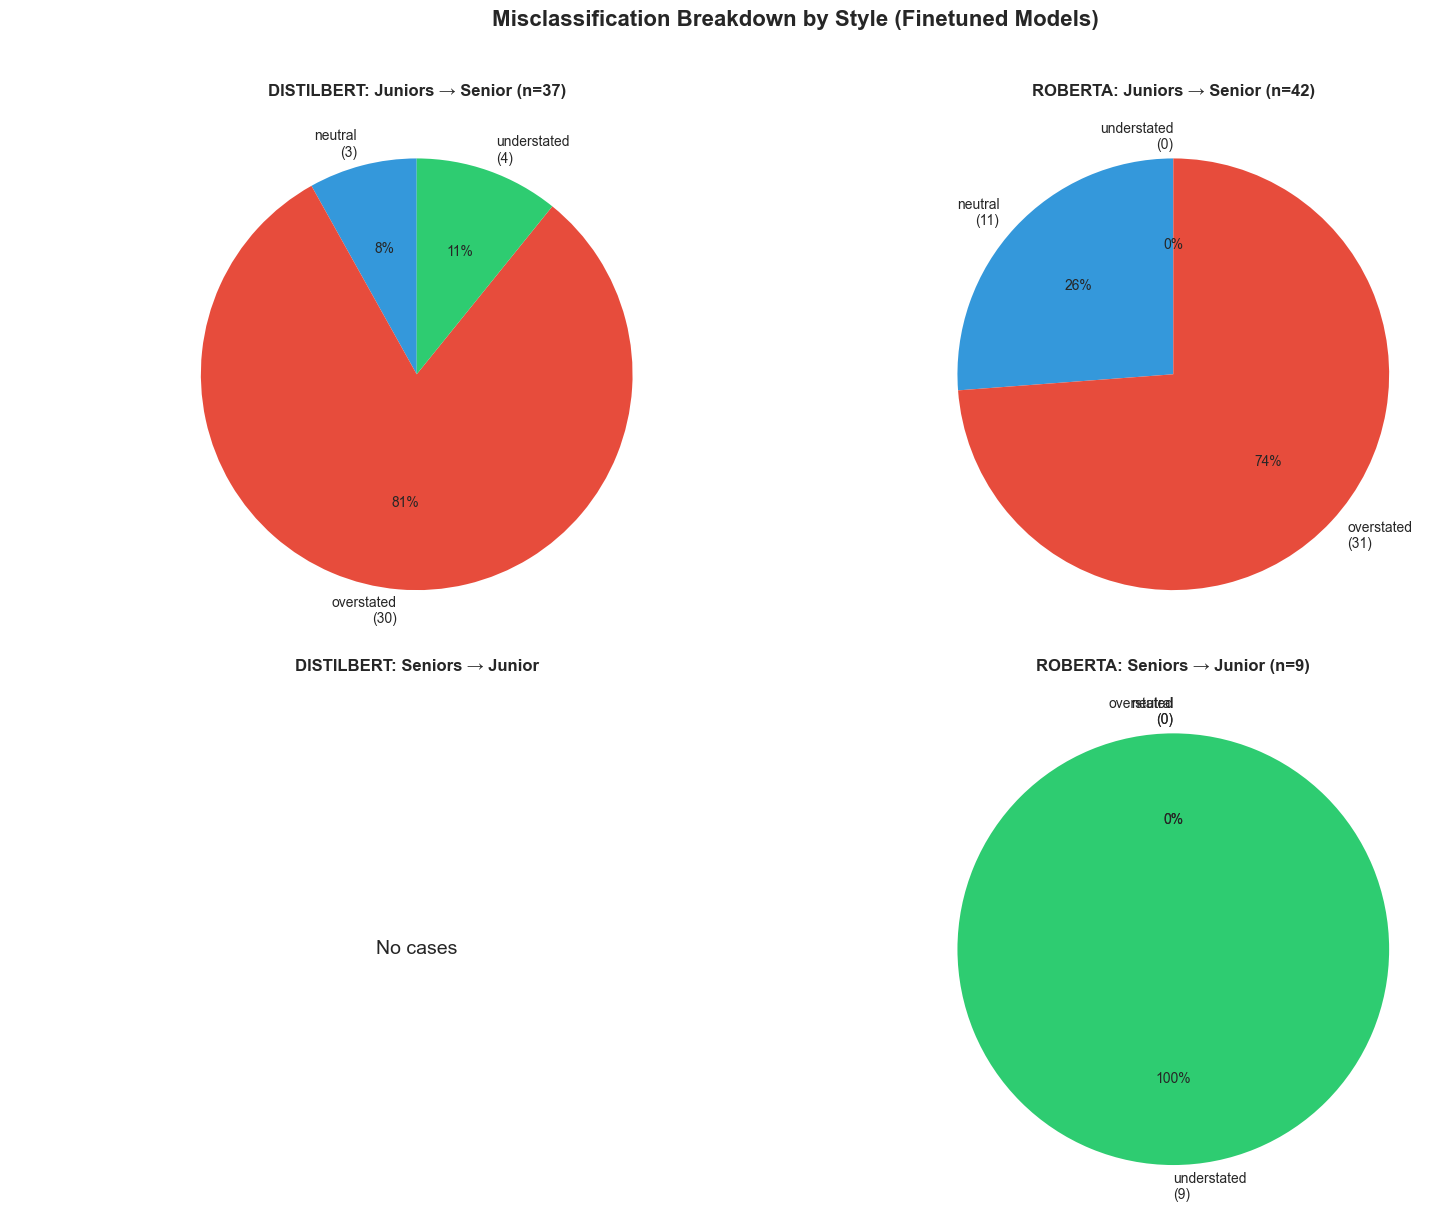

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

def get_misclass_breakdown(df, model, true_level, pred_level):
    subset = df[(df['model'] == model) & (df['true_seniority'] == true_level) & (df['prediction'] == pred_level)]
    if len(subset) == 0:
        return {'overstated': 0, 'neutral': 0, 'understated': 0}
    return subset['style'].value_counts().to_dict()

# Juniors predicted as Senior
if ft_df is not None:
    for idx, model in enumerate(ft_models):
        breakdown = get_misclass_breakdown(ft_df, model, 'junior', 'senior')
        total = sum(breakdown.values())
        if total > 0:
            sizes = [breakdown.get(s, 0) for s in styles]
            axes[0, idx].pie(sizes, labels=[f"{s}\n({breakdown.get(s,0)})" for s in styles], 
                            colors=[colors[s] for s in styles], autopct='%1.0f%%', startangle=90)
            axes[0, idx].set_title(f'{model.upper()}: Juniors → Senior (n={total})', fontsize=12, fontweight='bold')
        else:
            axes[0, idx].text(0.5, 0.5, 'No cases', ha='center', va='center', fontsize=14)
            axes[0, idx].set_title(f'{model.upper()}: Juniors → Senior', fontsize=12, fontweight='bold')
            axes[0, idx].axis('off')

# Seniors predicted as Junior
if ft_df is not None:
    for idx, model in enumerate(ft_models):
        breakdown = get_misclass_breakdown(ft_df, model, 'senior', 'junior')
        total = sum(breakdown.values())
        if total > 0:
            sizes = [breakdown.get(s, 0) for s in styles]
            axes[1, idx].pie(sizes, labels=[f"{s}\n({breakdown.get(s,0)})" for s in styles], 
                            colors=[colors[s] for s in styles], autopct='%1.0f%%', startangle=90)
            axes[1, idx].set_title(f'{model.upper()}: Seniors → Junior (n={total})', fontsize=12, fontweight='bold')
        else:
            axes[1, idx].text(0.5, 0.5, 'No cases', ha='center', va='center', fontsize=14)
            axes[1, idx].set_title(f'{model.upper()}: Seniors → Junior', fontsize=12, fontweight='bold')
            axes[1, idx].axis('off')

plt.suptitle('Misclassification Breakdown by Style (Finetuned Models)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('viz6_misclassification_breakdown_ft.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Visual 7: Heatmap - Full Prediction Matrix by Style

### What This Analysis Shows
A heatmap showing the distribution of predictions for each true seniority level, broken down by writing style. Each row is a true level (junior/mid/senior), and colors indicate how predictions were distributed.

### Why This Matters
This gives the complete picture of how style affects predictions at every level:
- Do juniors get different predictions based on style?
- Do seniors get different predictions based on style?
- Is the bias symmetric or does it affect some levels more?

### How to Interpret
- **Diagonal dominance (dark on diagonal)** = Good! Model predicts correctly regardless of style.
- **Off-diagonal heat for overstated** = Overstated resumes get mispredicted more.
- **Upper-right heat for overstated** = Overstated causes over-promotion.
- **Lower-left heat for understated** = Understated causes under-recognition.

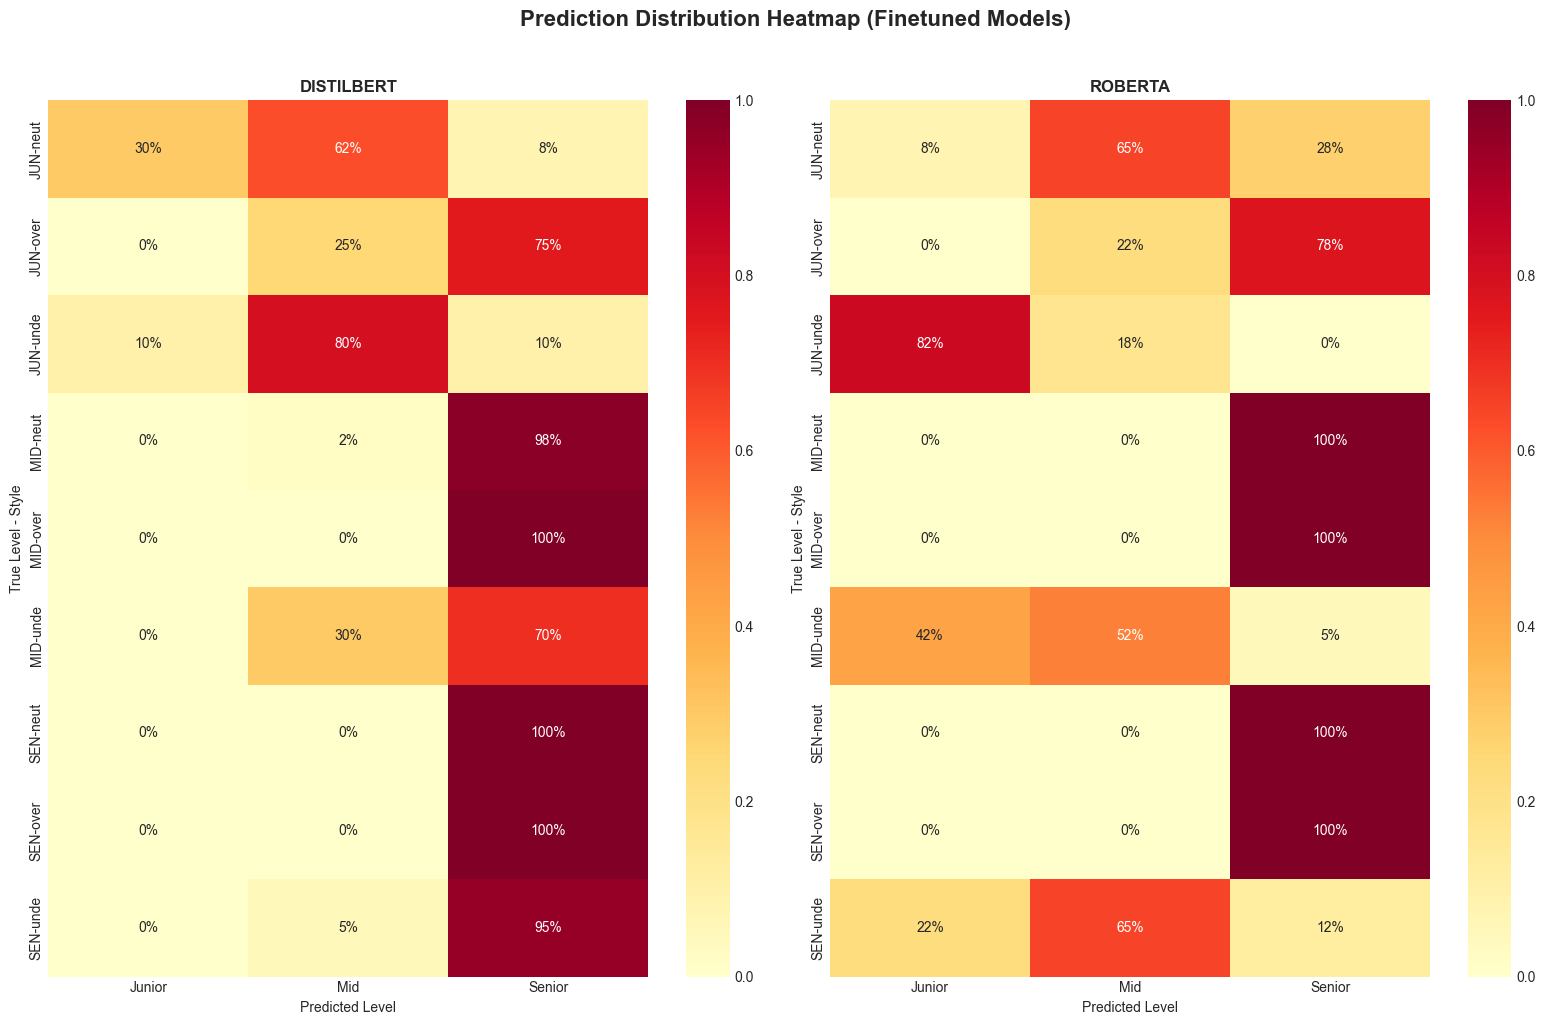

In [10]:
def create_prediction_heatmap(df, model, ax, title):
    model_df = df[df['model'] == model]
    
    data = []
    row_labels = []
    
    for true_level in ['junior', 'mid', 'senior']:
        for style in styles:
            subset = model_df[(model_df['true_seniority'] == true_level) & (model_df['style'] == style)]
            if len(subset) > 0:
                preds = subset['prediction'].value_counts(normalize=True)
                row = [preds.get('junior', 0), preds.get('mid', 0), preds.get('senior', 0)]
            else:
                row = [0, 0, 0]
            data.append(row)
            row_labels.append(f"{true_level[:3].upper()}-{style[:4]}")
    
    sns.heatmap(data, annot=True, fmt='.0%', cmap='YlOrRd', ax=ax,
                xticklabels=['Junior', 'Mid', 'Senior'], yticklabels=row_labels,
                vmin=0, vmax=1)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Level')
    ax.set_ylabel('True Level - Style')

if ft_df is not None:
    fig, axes = plt.subplots(1, len(ft_models), figsize=(8*len(ft_models), 10))
    if len(ft_models) == 1:
        axes = [axes]
    
    for idx, model in enumerate(ft_models):
        create_prediction_heatmap(ft_df, model, axes[idx], f'{model.upper()}')
    
    plt.suptitle('Prediction Distribution Heatmap (Finetuned Models)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('viz7_heatmap_finetuned.png', dpi=150, bbox_inches='tight')
    plt.show()

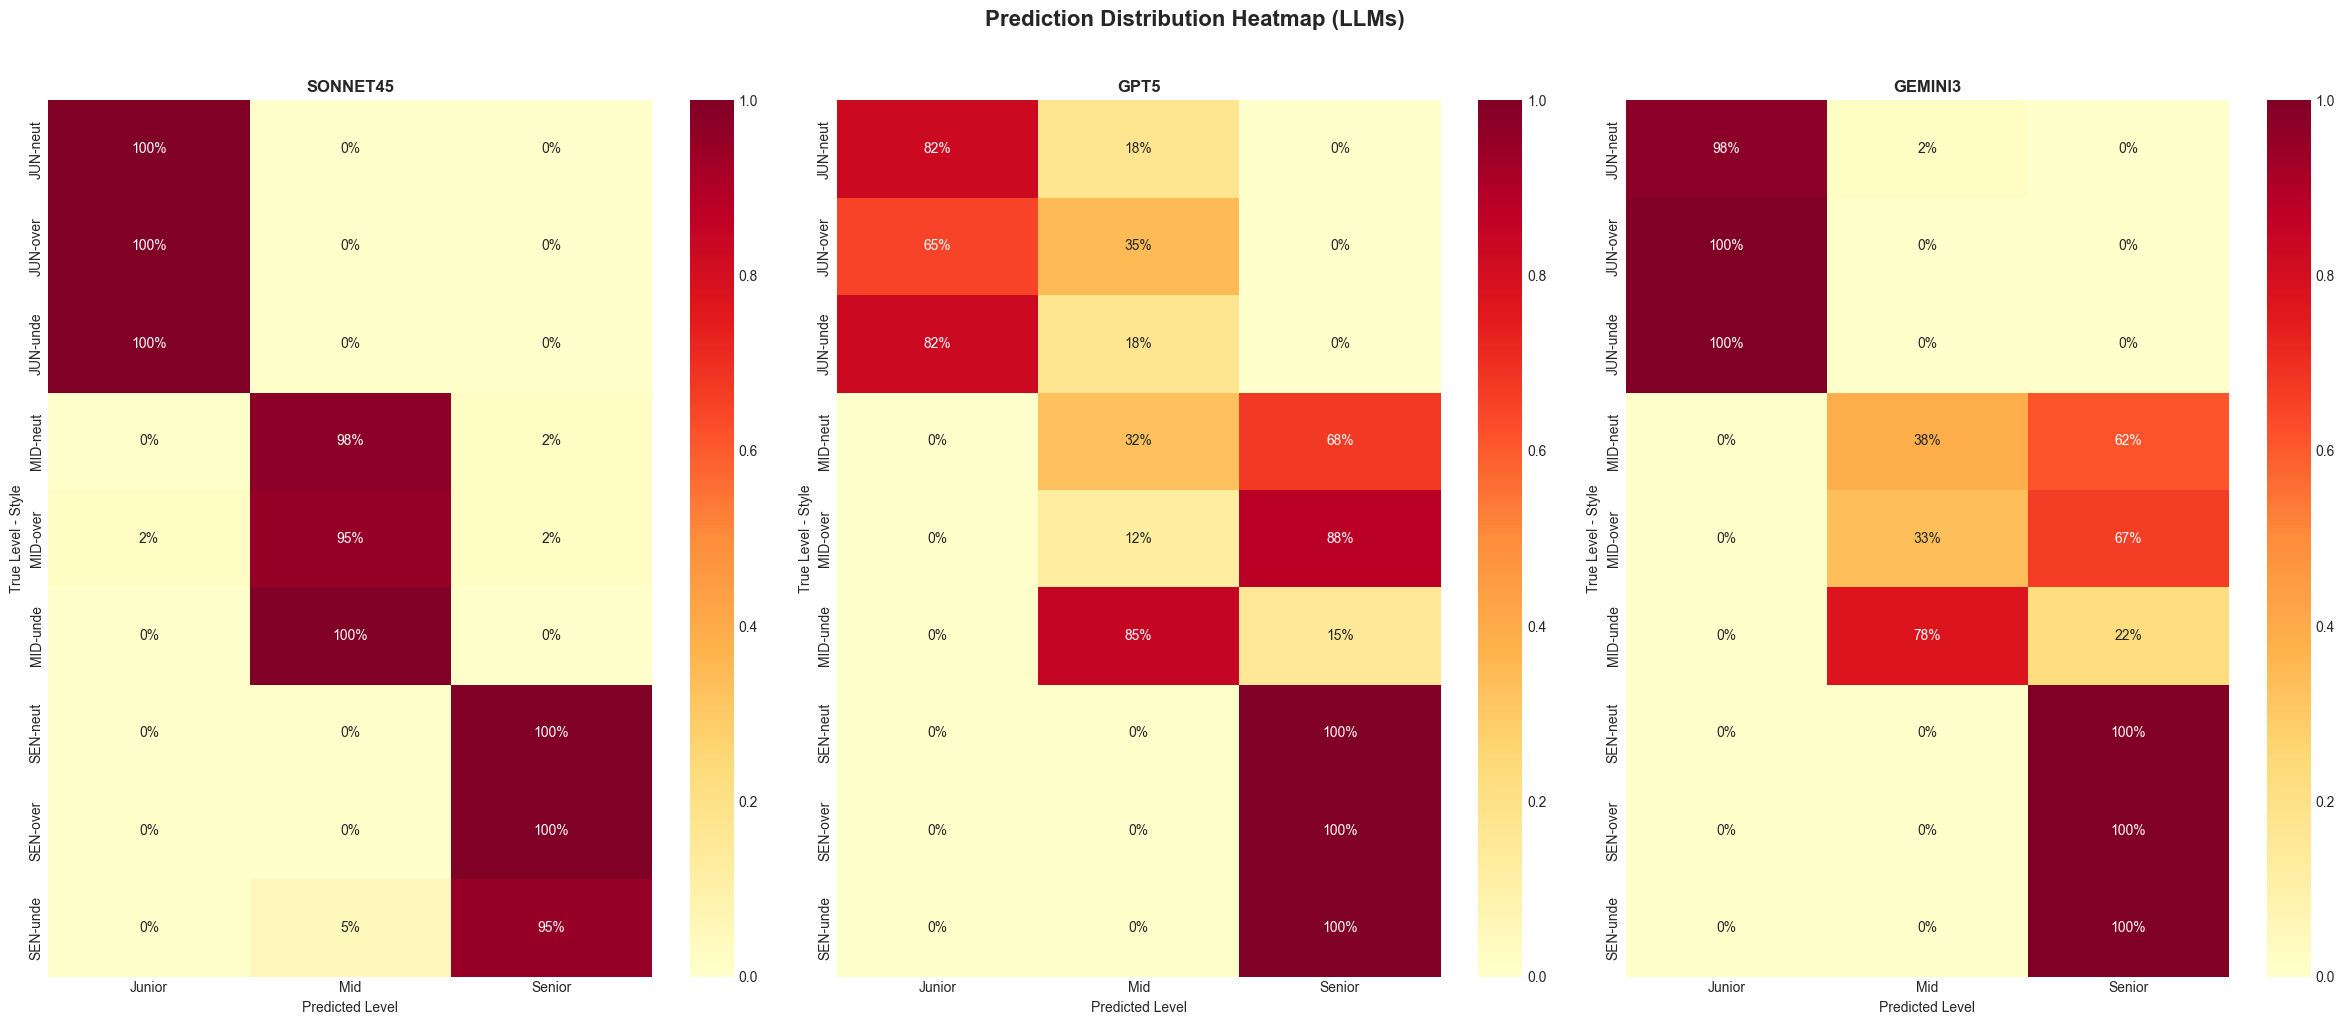

In [11]:
if llm_df is not None:
    fig, axes = plt.subplots(1, len(llm_models), figsize=(8*len(llm_models), 10))
    if len(llm_models) == 1:
        axes = [axes]
    
    for idx, model in enumerate(llm_models):
        create_prediction_heatmap(llm_df, model, axes[idx], f'{model.upper()}')
    
    plt.suptitle('Prediction Distribution Heatmap (LLMs)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('viz7_heatmap_llm.png', dpi=150, bbox_inches='tight')
    plt.show()

---
## Visual 8: Summary Dashboard

### What This Analysis Shows
A comprehensive comparison of all models on key metrics:
- Overall accuracy
- Style bias magnitude (overstated vs understated rank difference)
- Inconsistency rate

### How to Interpret
The ideal model has:
- High accuracy (tall green bar)
- Low style bias (short red bar)
- Low inconsistency (short orange bar)

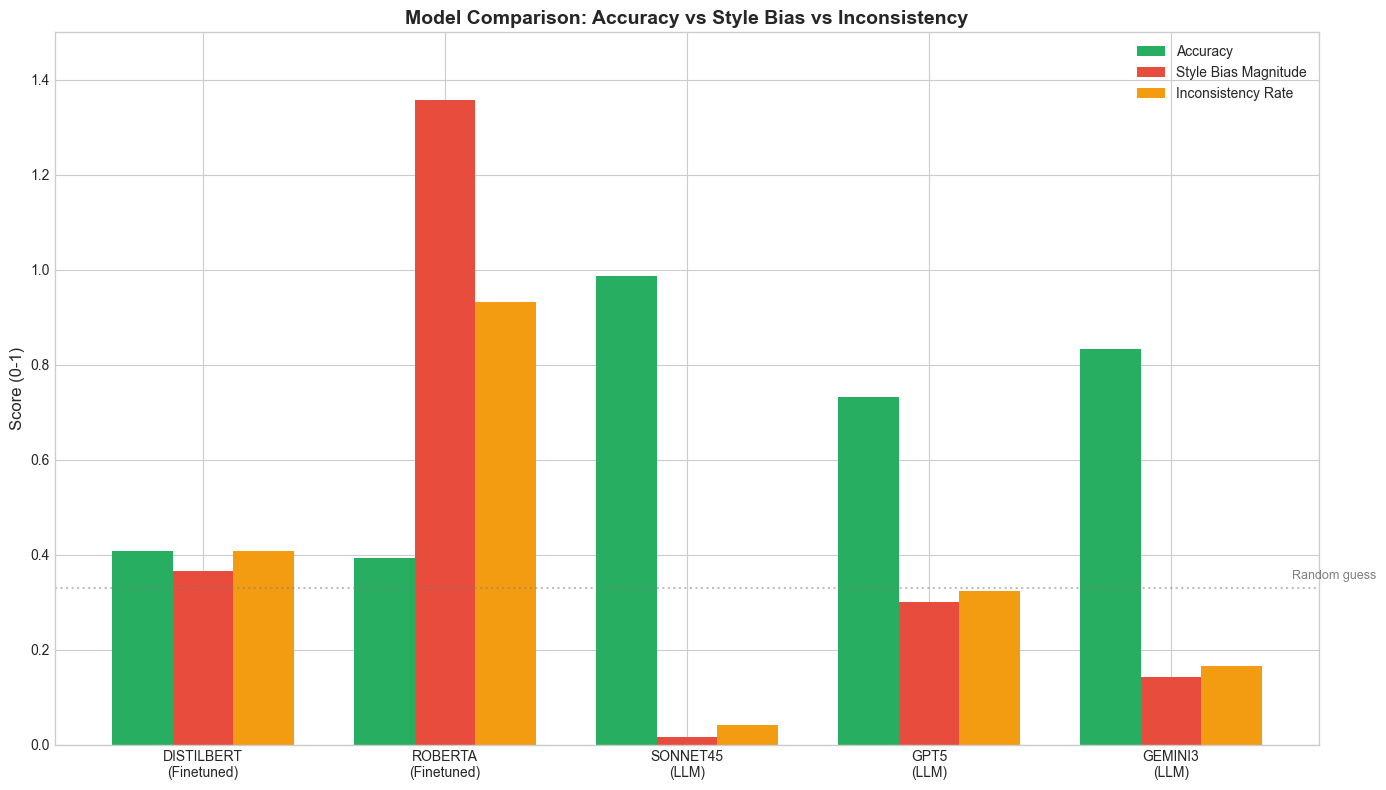

In [12]:
fig, ax = plt.subplots(figsize=(14, 8))

metrics = []
labels = []

def calc_metrics(df, model):
    model_df = df[df['model'] == model]
    
    acc = model_df['correct'].mean()
    
    over_bias = model_df[model_df['style'] == 'overstated']['rank_diff'].mean()
    under_bias = model_df[model_df['style'] == 'understated']['rank_diff'].mean()
    style_bias = abs(over_bias - under_bias)
    
    inconsistent = 0
    for idx in model_df['idx'].unique():
        if len(model_df[model_df['idx'] == idx]['prediction'].unique()) > 1:
            inconsistent += 1
    total = len(model_df['idx'].unique())
    inconsistency = inconsistent / total if total > 0 else 0
    
    return acc, style_bias, inconsistency

if ft_df is not None:
    for m in ft_models:
        metrics.append(calc_metrics(ft_df, m))
        labels.append(f"{m.upper()}\n(Finetuned)")

if llm_df is not None:
    for m in llm_models:
        metrics.append(calc_metrics(llm_df, m))
        labels.append(f"{m.upper()}\n(LLM)")

x = np.arange(len(labels))
width = 0.25

accs = [m[0] for m in metrics]
biases = [m[1] for m in metrics]
incons = [m[2] for m in metrics]

ax.bar(x - width, accs, width, label='Accuracy', color='#27ae60')
ax.bar(x, biases, width, label='Style Bias Magnitude', color='#e74c3c')
ax.bar(x + width, incons, width, label='Inconsistency Rate', color='#f39c12')

ax.set_ylabel('Score (0-1)', fontsize=12)
ax.set_title('Model Comparison: Accuracy vs Style Bias vs Inconsistency', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')
ax.set_ylim(0, 1.5)

# Add annotations
ax.axhline(y=0.33, color='gray', linestyle=':', alpha=0.5)
ax.text(len(labels)-0.5, 0.35, 'Random guess', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('viz8_summary_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Summary

All visualizations have been saved as PNG files:
1. `viz1_accuracy_by_style.png` - How accuracy varies by writing style
2. `viz2_bias_by_style.png` - Direction and magnitude of prediction bias
3. `viz3_junior_promotion_rate.png` - How often juniors get "promoted" to senior
4. `viz4_inconsistency_rate.png` - How often style changes the prediction
5. `viz5_power_words_by_prediction.png` - Word count analysis
6. `viz6_misclassification_breakdown_ft.png` - Which styles cause which errors
7. `viz7_heatmap_*.png` - Full prediction distribution
8. `viz8_summary_dashboard.png` - Overall model comparison